#  VGGNet
VGGNet is the 1st runner-up, not the winner of the ILSVRC-2014 in the classification task. VGGNet beats the GoogLeNet and won the localization task in ILSVRC 2014

### The highlights of the paper
- The Use of 3×3 Filters instead of large-size filters (such as 11×11, 7×7).
- Multi-Scale Training & Testing
- Dense (Convolutionalized) Testing
- Model Fusion

### The architecture
During training, the input to our ConvNets is a fixed-size 224 × 224 RGB image. The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel. The image is passed through a stack of convolutional (conv.) layers. All hidden layers are equipped with the rectification (ReLU (Krizhevsky et al., 2012)) non-linearity. The width of conv. layers (the number of channels) is rather small, starting from 64 in the first layer and then increasing by a factor of 2 after each max-pooling layer, until it reaches 512. Number of layers depend on VGG-11, VGG-11 (LRN), VGG-13, VGG-16 (Conv1), VGG-16 and VGG-19 architechure.
![orignal_architeture](./images/original_architechure.png)


# VGGNet implementation on Cifar 10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Data Loading and Preprocessing

### CIFAR10 small image classification
Dataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

#### Returns 2 tuples:
- **x_train, x_test**: uint8 array of RGB image data with shape (num_samples, 32, 32, 3).
- **y_train, y_test**: uint8 array of category labels (integers in range 0-9) with shape (num_samples,).

In [2]:
is_gpu_available = torch.cuda.is_available()
if is_gpu_available:
    print("Traning on Gpu")
else:
    print("Traning on Cpu")

Traning on Gpu


In [3]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, RandomHorizontalFlip, ToTensor, RandomRotation, Normalize

transform = Compose([
    RandomHorizontalFlip(),
    RandomRotation(10),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CIFAR10('data', transform=transform, train=True, download=True)
test_data = CIFAR10('data', transform=transform, train=False, download=True)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

print("Number of training examples =", len(train_data))
print("Number of testing examples =", len(test_data))
print("Image data shape =", train_data[0][0].shape)
print("Number of classes =", len(classes))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples = 50000
Number of testing examples = 10000
Image data shape = torch.Size([3, 32, 32])
Number of classes = 10


In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(dataset=train_data, batch_size=20, sampler=train_sampler)
valid_loader = DataLoader(dataset=train_data, batch_size=20, sampler=valid_sampler)
test_loader = DataLoader(dataset=test_data, batch_size=20)

## Visualize a Batch of Training Data

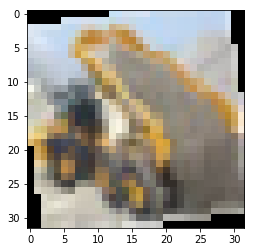

In [5]:
def imshow(image):
    img = image.numpy()
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(images[0])

## Model Implementation

In [6]:
from torch.nn import Module, Conv2d, Linear, MaxPool2d, Dropout, Dropout2d, BatchNorm2d, BatchNorm1d
import torch.nn.functional as F

### Model Architecture
The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.

![vggnet.jpg](./images/vggnet.jpg)

In [11]:
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = Conv2d(3, 64, 3, padding=1)
        self.conv1_bn = BatchNorm2d(64)
        
        self.conv2 = Conv2d(64, 128, 3, padding=1)
        self.conv2_bn = BatchNorm2d(128)
        
        self.conv3 = Conv2d(128, 256, 3, padding=1)
        self.conv4 = Conv2d(256, 256, 3, padding=1)
        self.conv4_bn = BatchNorm2d(256)
        
        self.conv5 = Conv2d(256, 512, 3, padding=1)
        self.conv6 = Conv2d(512, 512, 3, padding=1)
        self.conv6_bn = BatchNorm2d(512)
        
        self.conv7 = Conv2d(512, 512, 3, padding=1)
        self.conv8 = Conv2d(512, 512, 3, padding=1)
        self.conv8_bn = BatchNorm2d(512)
        
        self.pool = MaxPool2d(2, stride=2)
        
        self.dropout_2d = Dropout2d(0.25)
        
        self.dropout_1d = Dropout(0.25)
        
        self.fc1 = Linear(512 * 1 * 1, 4096)
        self.fc1_bn = BatchNorm1d(4096)
        
        self.fc2 = Linear(4096, 4096)
        self.fc2_bn = BatchNorm1d(4096)
        
        self.fc3 = Linear(4096, 1000)
        self.fc3_bn = BatchNorm1d(1000)
        
        self.fc4 = Linear(1000, 10)
        
    def forward(self, x):
        x = self.dropout_2d(F.relu(self.conv1(x)))
        x = self.conv1_bn(self.pool(x))
        
        x = self.dropout_2d(F.relu(self.conv2(x)))
        x = self.conv2_bn(self.pool(x))
        
        x = self.dropout_2d(F.relu(self.conv3(x)))
        x = self.dropout_2d(F.relu(self.conv4(x)))
        x = self.conv4_bn(self.pool(x))
        
        x = self.dropout_2d(F.relu(self.conv5(x)))
        x = self.dropout_2d(F.relu(self.conv6(x)))
        x = self.conv6_bn(self.pool(x))
        
        x = self.dropout_2d(F.relu(self.conv7(x)))
        x = self.dropout_2d(F.relu(self.conv8(x)))
        x = self.conv8_bn(self.pool(x))
        
        x = x.view(-1, 1 * 1 * 512)
        
        x = F.relu(self.fc1(x))
        x = self.fc1_bn(self.dropout_1d(x))
        
        x = F.relu(self.fc2(x))
        x = self.fc2_bn(self.dropout_1d(x))
        
        x = F.relu(self.fc3(x))
        x = self.fc3_bn(self.dropout_1d(x))
        
        x = self.fc4(x)
        
        return x
        
        

In [12]:
# create a complete CNN
model = Net()
print(model)

if is_gpu_available:
    model.cuda()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padd

In [13]:
from torch.nn import CrossEntropyLoss
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training

In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
total_train_loss = []
total_valid_loss = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    total_train_loss.append(train_loss)
    total_valid_loss.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.517203 	Validation Loss: 0.315081
Validation loss decreased (inf --> 0.315081).  Saving model ...
Epoch: 2 	Training Loss: 1.320906 	Validation Loss: 0.284388
Validation loss decreased (0.315081 --> 0.284388).  Saving model ...
Epoch: 3 	Training Loss: 1.222106 	Validation Loss: 0.256347
Validation loss decreased (0.284388 --> 0.256347).  Saving model ...
Epoch: 4 	Training Loss: 1.141128 	Validation Loss: 0.234619
Validation loss decreased (0.256347 --> 0.234619).  Saving model ...
Epoch: 5 	Training Loss: 1.081302 	Validation Loss: 0.224059
Validation loss decreased (0.234619 --> 0.224059).  Saving model ...
Epoch: 6 	Training Loss: 1.023276 	Validation Loss: 0.205529
Validation loss decreased (0.224059 --> 0.205529).  Saving model ...
Epoch: 7 	Training Loss: 0.973108 	Validation Loss: 0.195605
Validation loss decreased (0.205529 --> 0.195605).  Saving model ...
Epoch: 8 	Training Loss: 0.932711 	Validation Loss: 0.184554
Validation loss decreased (0.19560

## Testing

In [ ]:
model.evaluate(x=x_test, y=y_test)

In [ ]:
model.save('model.h5')
history = model.history

## Results
 
### Training from scratch

Training AlexNet, using stochastic gradient descent with a fixed learning rate of 0.01, for 50 epochs, we acheive a test accuracy of ~76.75%.

In accuracy and loss plot shown below, notice the large gap between the training and testing curves. This suggests that our model is overfitting.

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Todo
- Expriment to stop model overfiting